In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import itertools

import pandas as pd
import upath
import extras

In [3]:
import logging

# set up handler
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

# set up logger
logger = logging.getLogger(__name__)

# set levels
logging.getLogger().setLevel("INFO")
logger.setLevel("DEBUG")
logging.getLogger("extras").setLevel("INFO")

In [4]:
path_root = upath.UPath("gs://liulab/differential_composition_and_expression/20230310_21h01m15s")
# print(extras.get_parquet_paths(path_root))
# !gsutil ls "{path_root}/*"

In [5]:
df_gene_stats = extras.load_gene_stats(path_root)

In [6]:
df_gene_stats.groupby("malignant_means	log2_fc	run_id".split("\t")).size()

malignant_means  log2_fc  run_id
0.55,0.85        -1.50    00        16063
                          01        16063
                 -1.00    00        16063
                          01        16063
                 -0.50    00        16063
                                    ...  
0.85,0.55        0.50     01            0
                 1.00     00        16063
                          01            0
                 1.50     00        16063
                          01            0
Length: 112, dtype: int64

## ROC (TPR, FPR)

In [7]:
df_roc_curves, df_roc_auc_scores = extras.calculate_roc(df_gene_stats)

In [8]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

(
    df_roc_auc_scores
    .groupby(["malignant_means", "log2_fc"])
    .mean()
    .unstack("log2_fc")
    .sort_index(axis=1, key=lambda index: index.astype(float))
).style.background_gradient(cmap=cm)

log2_fc,-1.50,-1.00,-0.50,0.00,0.50,1.00,1.50
malignant_means,,,,,,,
"0.55,0.85",0.587264,0.570288,0.547715,0.571725,0.572468,0.572856,0.564371
"0.65,0.75",0.571590,0.540730,0.555714,0.593835,0.588482,0.627971,0.622006
"0.7,0.72",0.574094,0.586030,0.598501,0.541592,0.570427,0.585454,0.585530
"0.71,0.71",0.564591,0.568569,0.625195,0.561110,0.591516,0.615002,0.576841
"None,None",0.553541,0.550392,0.577299,0.577536,0.589279,0.545593,0.591248
"0.72,0.7",0.614647,0.525696,0.583401,0.568074,0.600537,0.596012,0.578167
"0.75,0.65",0.586253,0.571889,0.587961,0.583943,0.610868,0.609395,0.566565
"0.85,0.55",0.531557,0.572068,0.589751,0.536513,0.558048,0.561276,0.586903


In [12]:
fig = extras.plot_roc(df_roc_curves)

In [10]:
for row, col in itertools.product(*fig._get_subplot_rows_columns()):
    # print(row, col)
    fig.add_shape(
        type="line",
        line=dict(dash="dash"),
        x0=0,
        x1=1,
        y0=0,
        y1=1,
        row=row,
        col=col,
    )

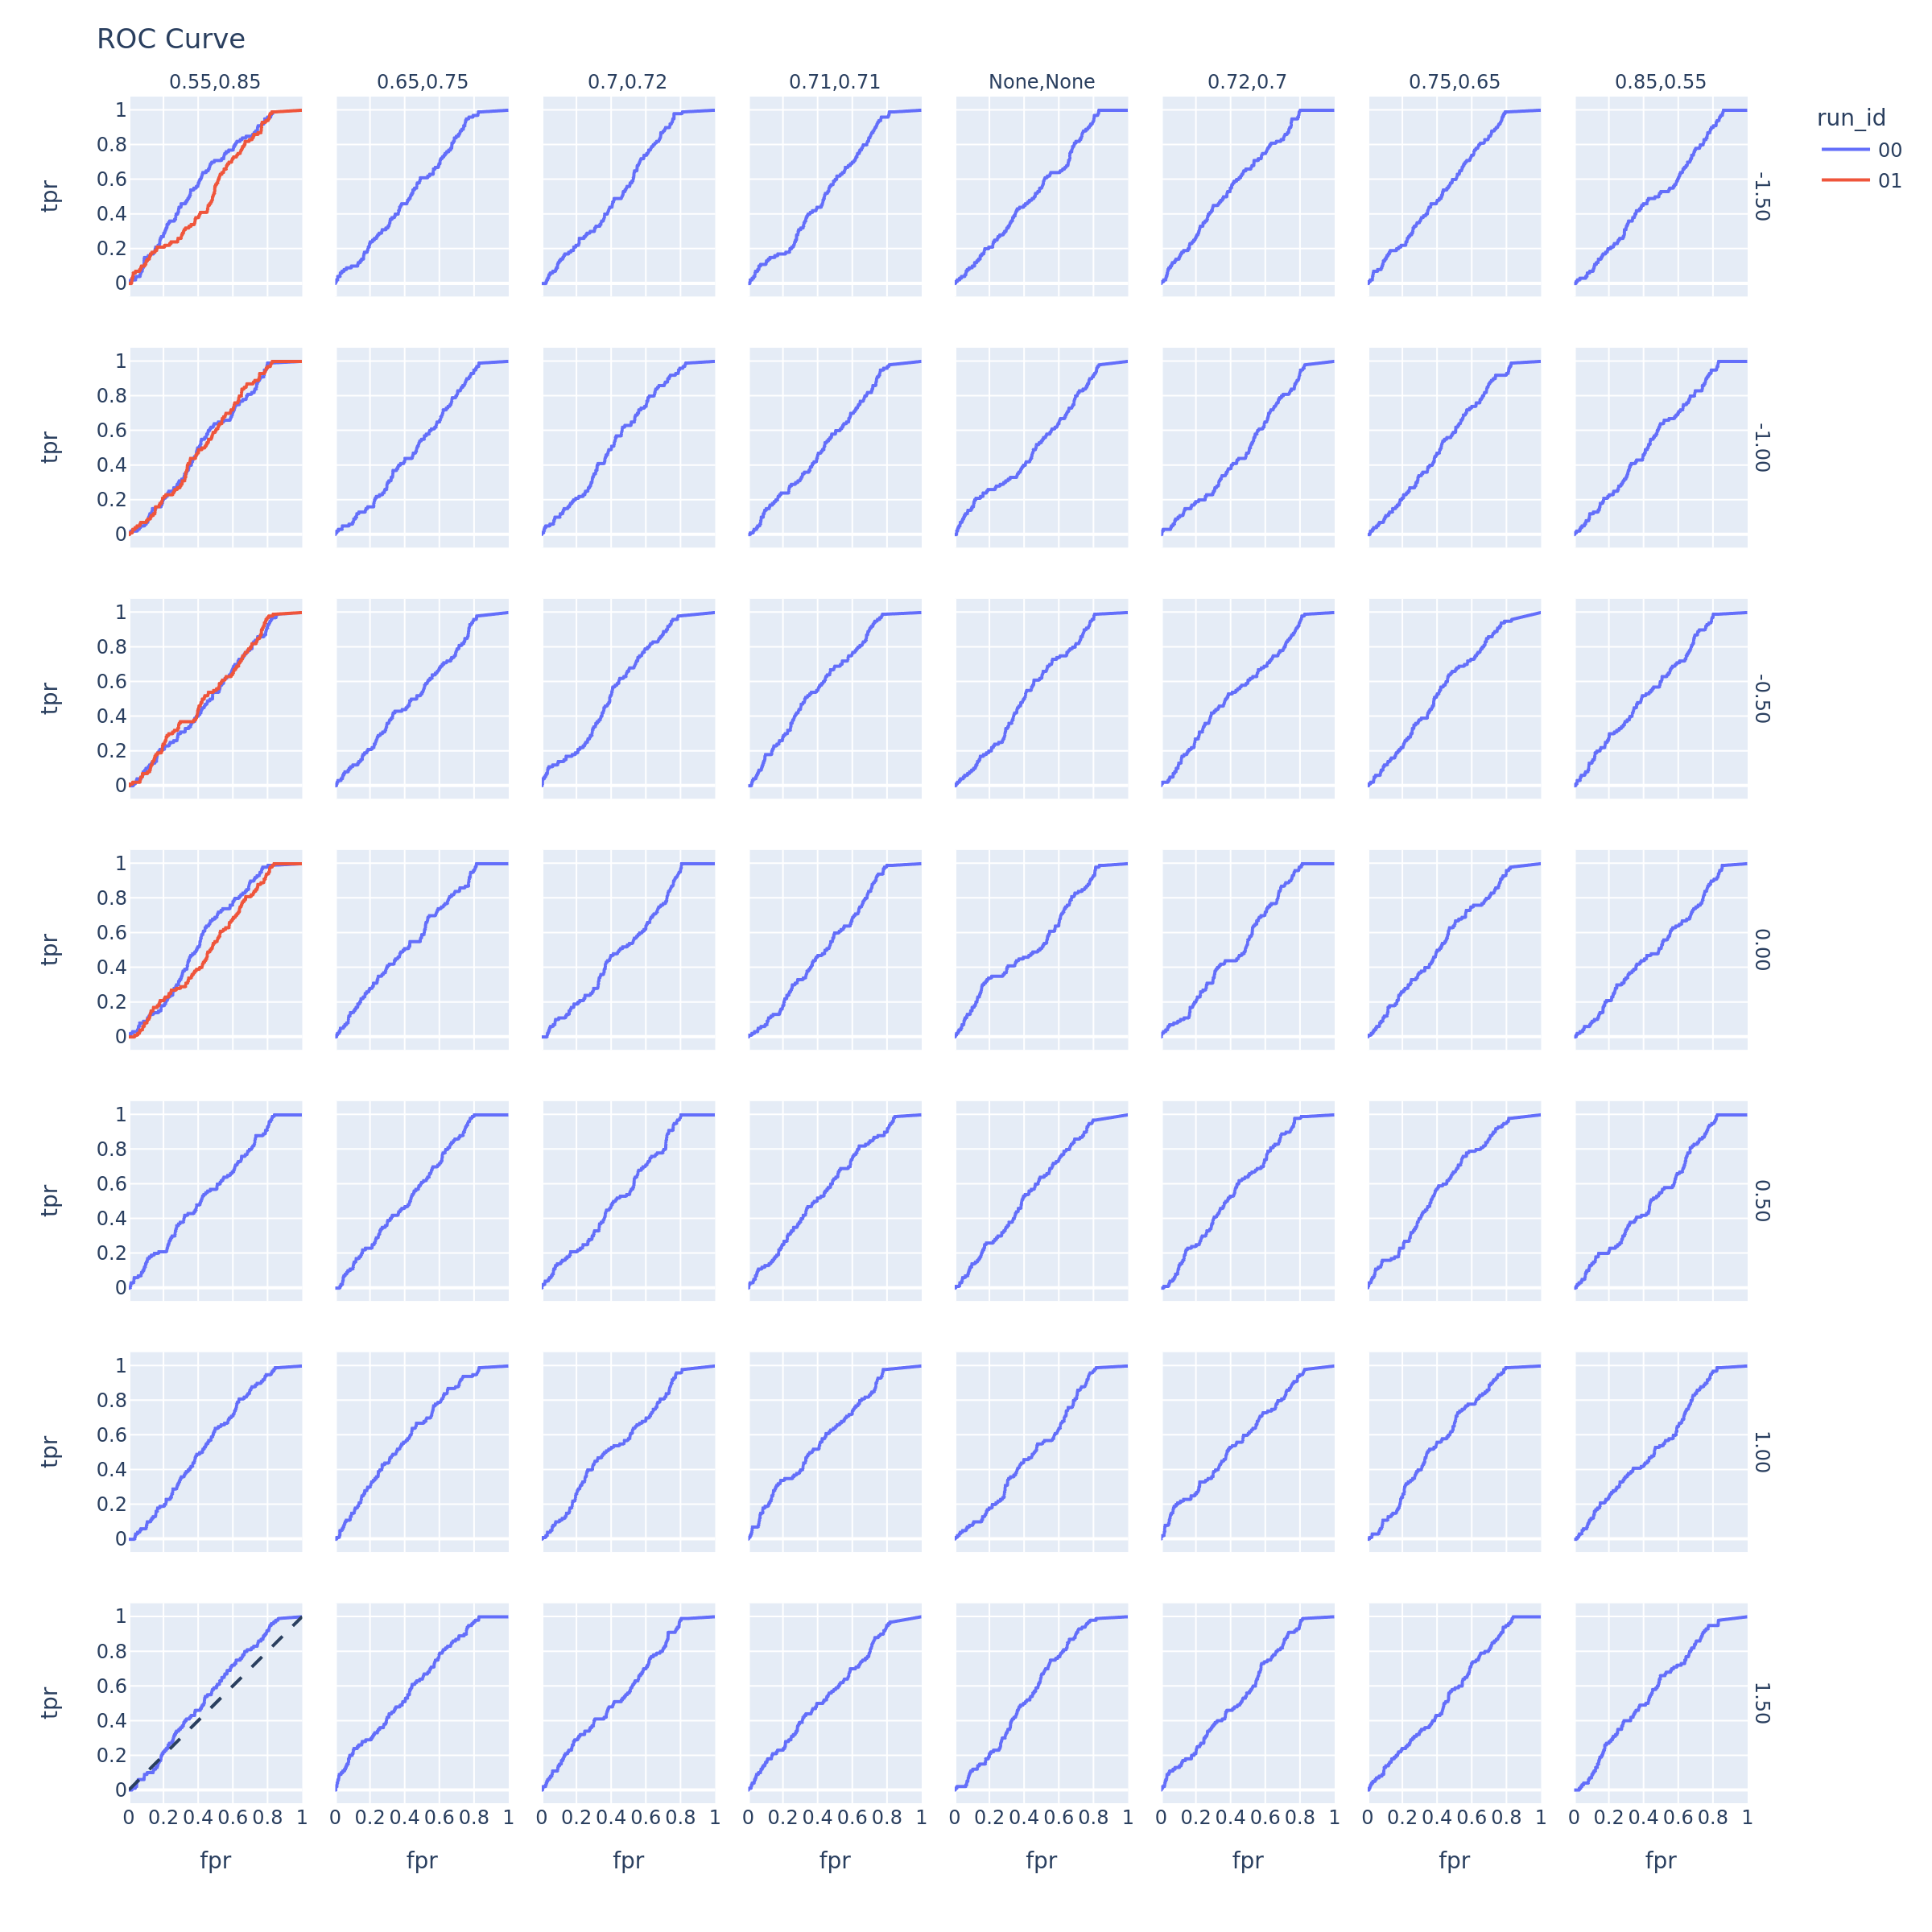

In [15]:
fig.update_layout(width=1200, height=1200)
fig.show(renderer="png", scale=2)

## precision and recall

In [ ]:
df_prc = extras.calculate_precision_and_recall(df_gene_stats)
df_prc

In [ ]:
fig = extras.plot_precision_recall_curve(df_prc)

In [ ]:
fig.update_layout(width=1200, height=2000)
fig.show(renderer="png", scale=2)